In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np 

mnist_train = torchvision.datasets.FashionMNIST("~/Datasets/FashionMNIST",train=True,download=True,transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST("~/Datasets/FashionMNIST",train=False,download=True,transform=transforms.ToTensor())

batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=4)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,num_workers=4)

print(len(train_iter),len(test_iter))

num_inputs = 28 * 28 # 输入节点个数，每个像素对应一个节点
num_outputs = 10 # 输出节点个数，每个类别对应一个节点

# 初始化参数，权重w和bias b
# 权重矩阵的行数对应于输入节点的个数，列数对应于输出个数。 也就是，每一列都生成一个输出。
W = torch.tensor(np.random.normal(0,0.01,(num_inputs,num_outputs)),dtype=torch.float32)
b = torch.zeros(num_outputs,dtype=torch.float)

W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

235 40


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [2]:
def load_data_fashion_mnist(batch_size):

    mnist_train = torchvision.datasets.FashionMNIST("~/Datasets/FashionMNIST",train=True,download=True,transform=transforms.ToTensor())
    mnist_test = torchvision.datasets.FashionMNIST("~/Datasets/FashionMNIST",train=False,download=True,transform=transforms.ToTensor())

    
    train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=4)
    test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,num_workers=4)

    return train_iter,test_iter

## 实现softmax

如果对多维度的`tensor`对其**按维度操作**。 下面的代码中，矩阵$X$，对其中的同一列(dim=0)或者同一行(dim=1)进行操作

In [3]:
x = torch.tensor([[1,2,3,],[4,5,6]])
print(x.sum(dim=0,keepdim=True)) # 维度 hxw,dim=0，对行进行操作，求每一列的和
print(x.sum(dim=1,keepdim=True)) # 维度 hxw,dim=1，对列进行操作，求每一行的和

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


In [4]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1,keepdim=True)
    return X_exp / partition

In [5]:
# 定义模型
def net(X):
    X = X.float()
    return softmax(torch.mm(X.view(-1,num_inputs),W) + b)

In [6]:
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]]) # 2个样本，对应与3个类别的概率
y = torch.LongTensor([0,2]) # 样本对应的真实类别
y_hat.gather(1,y.view(-1,1)) # 取到真实的类别的预测概率

tensor([[0.1000],
        [0.5000]])

In [7]:
# 定义损失函数
def cross_entropy(y_hat,y):
    return -torch.log(y_hat.gather(1,y.view(-1,1)))

# 计算精度Accuracy
def accuracy(y_hat,y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

def evaluate_accuracy(data_iter,net):
    acc_sum,n = 0.0,0
    for X,y in data_iter:
        acc_sum += (net(X).argmax(dim=1) ==y).float().sum().item()
        n += y.shape[0]

    return acc_sum / n

In [12]:
# 训练模型
import d2lzh as d2l
num_epochs = 5
lr = 0.1

def train_ch3(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n = 0.0,0.0,0
        for X,y in train_iter:
            y_hat = net(X)
            l = loss(y_hat,y).sum()

            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                # d2l.sgd(net,lr,batch_size)
                for param in params:
                    param.data -= lr * param.grad / batch_size
            else:
                optimizer.step()

            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            test_acc = evaluate_accuracy(test_iter,net)

        print("epoch %d,loss %.4f,train acc %.3f,test_acc %.3f" % (epoch +1,train_l_sum / n ,train_acc_sum / n,test_acc))


train_ch3(net,train_iter,test_iter,cross_entropy,num_epochs,batch_size,[W,b],lr,None)

epoch 1,loss 0.7867,train acc 0.748,test_acc 0.796
epoch 2,loss 0.5713,train acc 0.813,test_acc 0.811
epoch 3,loss 0.5257,train acc 0.826,test_acc 0.820
epoch 4,loss 0.5017,train acc 0.832,test_acc 0.825
epoch 5,loss 0.4855,train acc 0.838,test_acc 0.828


[7 1 4 2 0 8 0 0 2 5 4 5 4 9 8 5 4 3 0 6 4 0 6 7 7 5 0 4 4 4 0 3 9 0 2 4 9
 5 6 3 9 4 4 0 1 5 7 0 8 5 5 0 1 4 2 9 1 8 3 0 8 0 2 0 2 3 2 5 8 6 5 6 3 9
 0 8 5 1 7 5 1 2 7 8 1 9 2 5 6 1 0 4 1 9 5 5 5 9 5 8 2 9 4 9 3 1 4 2 7 4 0
 7 6 8 4 4 1 0 3 8 5 6 1 8 7 5 4 5 4 0 9 8 8 3 7 9 9 1 3 6 6 0 7 2 2 9 5 5
 1 3 8 2 9 3 5 2 0 0 9 8 1 8 8 5 9 5 2 5 6 4 1 4 6 2 7 3 3 7 5 7 2 6 9 4 6
 5 4 9 6 2 8 4 3 8 2 2 0 4 4 8 4 4 3 9 8 6 1 5 8 1 8 1 2 2 2 6 3 0 3 4 9 3
 1 4 0 5 3 6 2 4 3 0 0 6 1 6 0 7 1 0 3 0 0 8 3 0 5 2 9 4 4 9 5 5 4 1]


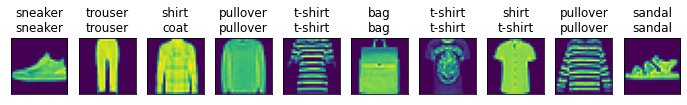

In [13]:
import d2lzh as d2l

X,y = iter(test_iter).next()

X,y = iter(train_iter).next()
print(net(X).argmax(dim=1).numpy())
true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())



titles = [true + "\n" + pred for true,pred in zip(true_labels,pred_labels)]

d2l.show_fashion_mnist(X[0:10],titles[0:10])